# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *

In [136]:
df = pd.read_csv('famcs_students.csv')
df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [138]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 14
target_col = binary_cols[N % 8]
print(f"Целевая переменная (y): {target_col}")

Целевая переменная (y): study_form


#### Признаки для предсказания формы обучения
- ss - студсоюз
- weekend_study - учеба в выходные
- bad_sleep - сон
- score - ср. балл
- retake - пересды
- miss - пропуски
- work_experience - опыт работы

In [141]:
feature_cols = ['ss', 'weekend_study', 'bad_sleep', 'score', 'retake', 'miss',  'work_experience']

df_model = df[feature_cols + [target_col]].copy()

vals = df_model[target_col].value_counts()
major_class = vals.idxmax()
minor_class = vals.idxmin()

print(f"Класс 0: {major_class}")
print(f"Класс 1: {minor_class}")

df_model['y'] = df_model[target_col].apply(lambda x: 0 if x == major_class else 1)

Класс 0: Бюджет
Класс 1: Платная


In [143]:
def binarize(x):
    return 1 if str(x).lower() in ['да', 'yes', '1', 'true'] else 0

for col in ['ss', 'weekend_study', 'bad_sleep']:
    df_model[col] = df_model[col].apply(binarize)

num_cols = ['score', 'miss', 'retake']
df_model[num_cols] = df_model[num_cols].apply(pd.to_numeric, errors='coerce')
df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

map_exp = {
    "Не работаю": 0,
    "Меньше года": 1,
    "1-2 года": 2,
}

df_model["work_experience_enc"] = df_model["work_experience"].map(map_exp)


In [145]:
df_model

,ss,weekend_study,bad_sleep,score,retake,miss,work_experience,study_form,y,work_experience_enc
0,0,1,1,9.20,0.0,3.0,Меньше года,Бюджет,0,1.0
1,0,0,0,8.80,0.0,5.0,1-2 года,Бюджет,0,2.0
2,0,1,0,8.80,0.0,10.0,Меньше года,Бюджет,0,1.0
3,0,1,1,8.80,0.0,3.0,1-2 года,Бюджет,0,2.0
4,0,1,0,9.00,0.0,1.0,Не работаю,Бюджет,0,0.0
...,...,...,...,...,...,...,...,...,...,...
122,0,0,0,6.29,0.0,1.0,Не работаю,Бюджет,0,0.0
123,0,1,1,6.00,0.0,0.0,Не работаю,Бюджет,0,0.0
124,0,0,0,7.00,0.0,10.0,Не работаю,Бюджет,0,0.0
125,0,1,1,7.00,0.0,1.0,1-2 года,Бюджет,0,2.0


In [147]:
scaler = StandardScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])
df_model = df_model.drop(columns=['work_experience'])
feature_cols = [col for col in feature_cols if col != 'work_experience']

In [149]:
X = df_model[feature_cols]
y = df_model['y']

In [151]:
df_model

,ss,weekend_study,bad_sleep,score,retake,miss,study_form,y,work_experience_enc
0,0,1,1,1.130170,-0.323029,-0.558679,Бюджет,0,1.0
1,0,0,0,0.855284,-0.323029,-0.328315,Бюджет,0,2.0
2,0,1,0,0.855284,-0.323029,0.247597,Бюджет,0,1.0
3,0,1,1,0.855284,-0.323029,-0.558679,Бюджет,0,2.0
4,0,1,0,0.992727,-0.323029,-0.789044,Бюджет,0,0.0
...,...,...,...,...,...,...,...,...,...
122,0,0,0,-0.869624,-0.323029,-0.789044,Бюджет,0,0.0
123,0,1,1,-1.068916,-0.323029,-0.904226,Бюджет,0,0.0
124,0,0,0,-0.381701,-0.323029,0.247597,Бюджет,0,0.0
125,0,1,1,-0.381701,-0.323029,-0.789044,Бюджет,0,2.0


In [153]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 88
Размер валидационной выборки: 19
Размер тестовой выборки: 20


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [158]:
class TrivialClassifier:
    def fit(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        self.mode = unique[np.argmax(counts)]

    def predict(self, X):
        return np.full(X.shape[0], self.mode)

    def predict_proba(self, X):
        n = X.shape[0]
        probs = np.zeros((n, 2))
        probs[:, self.mode] = 1.0
        return probs

In [160]:
model = TrivialClassifier()
model.fit(X_train, y_train)
print("Предсказываемый класс (mode):", model.mode)

Предсказываемый класс (mode): 0


## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

In [30]:
class MyGaussianNB:
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y)

        self.classes = np.unique(y)

        self.params = {}

        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9,
                'prior': len(X_c) / len(X)
            }

    def _gaussian_pdf(self, x, mean, var):
        return (
            1 / np.sqrt(2 * np.pi * var)
            * np.exp(-((x - mean) ** 2) / (2 * var))
        )

    def predict(self, X):
        X = np.array(X, dtype=float)
        predictions = []

        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                likelihood = np.sum(np.log(self._gaussian_pdf(x,
                                                              self.params[c]['mean'],
                                                              self.params[c]['var'])))
                posteriors.append(prior + likelihood)
            predictions.append(self.classes[np.argmax(posteriors)])

        return np.array(predictions)

## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

In [33]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, features_train, labels_train):
        self.features_train = np.array(features_train, dtype=float)
        self.labels_train = np.array(labels_train)

    def predict(self, features_test):
        features_test = np.array(features_test, dtype=float)
        predictions = []

        for sample in features_test:
            distances = np.sqrt(np.sum((self.features_train - sample)**2, axis=1))
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.labels_train[nearest_indices]xx
            majority_label = np.bincount(nearest_labels).argmax()

            predictions.append(majority_label)

        return np.array(predictions)

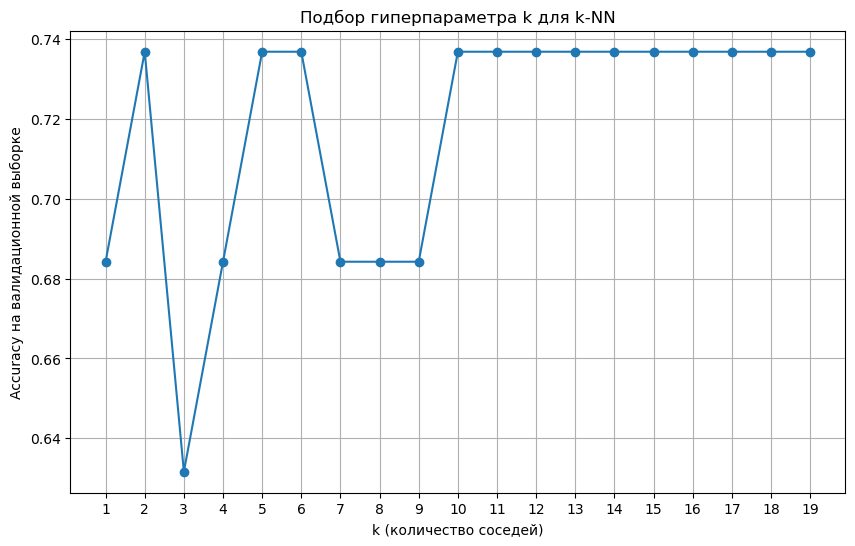


Оптимальное значение k: 2


In [35]:
k_values = range(1, 20, 1)
accuracies = []

for k in k_values:
    knn_clf = KNN(k=k)
    knn_clf.fit(X_train.values, y_train.values)
    y_val_pred = knn_clf.predict(X_val.values)
    accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Подбор гиперпараметра k для k-NN')
plt.xlabel('k (количество соседей)')
plt.ylabel('Accuracy на валидационной выборке')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"\nОптимальное значение k: {best_k}")

knn_clf_best = KNN(k=best_k)
knn_clf_best.fit(X_train.values, y_train.values)
y_test_pred = knn_clf_best.predict(X_test.values)

## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

In [38]:
class MyLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return np.where(y_pred > threshold, 1, 0)

In [40]:
log_reg = MyLogisticRegression(lr=0.1, epochs=1000)

log_reg.fit(X_train.values, y_train.values)

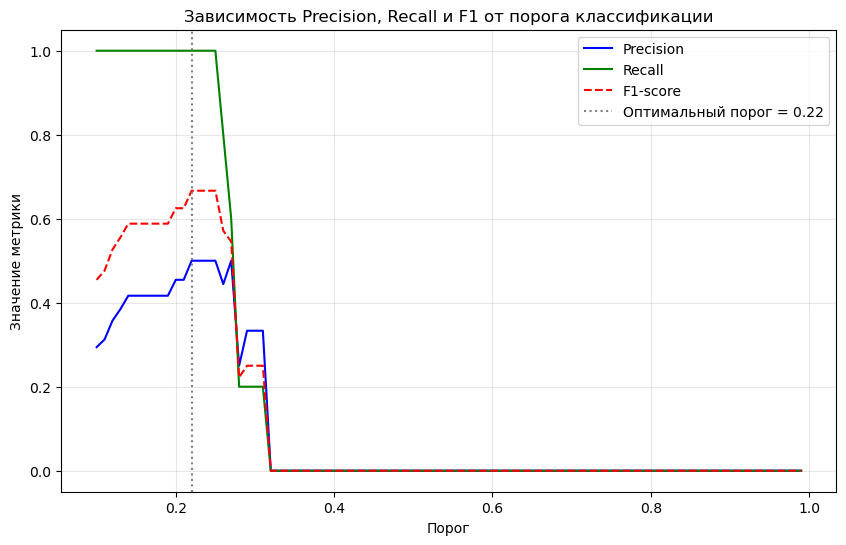

Оптимальный порог: 0.22, F1 = 0.6667


In [42]:
thresholds = np.arange(0.1, 1.0, 0.01)
f1_scores = []
precisions = []
recalls = []

y_val_proba = log_reg.predict_proba(X_val.values) 

for thresh in thresholds:
    y_pred_thresh = (y_val_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))
    precisions.append(precision_score(y_val, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thresh, zero_division=0))

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1-score', color='red', linestyle='--')
plt.axvline(x=best_thresh, color='gray', linestyle=':', label=f'Оптимальный порог = {best_thresh:.2f}')
plt.title('Зависимость Precision, Recall и F1 от порога классификации')
plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Оптимальный порог: {best_thresh:.2f}, F1 = {f1_scores[best_idx]:.4f}")

## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок

In [59]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

def print_metrics(name, y_true, y_pred, y_prob=None):
   
    if y_prob is None:
        y_prob = y_pred.astype(float)

    if len(y_prob.shape) == 2 and y_prob.shape[1] == 2:
        y_prob = y_prob[:, 1]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    try:
        roc = roc_auc_score(y_true, y_prob)
    except:
        roc = float('nan')
    cm = confusion_matrix(y_true, y_pred)


    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision:     {prec:.3f}")
    print(f"Recall:        {rec:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"ROC-AUC:       {roc:.3f}")
    print("Confusion matrix:")
    print(cm)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



Тривиальный классификатор
-------------------------
Accuracy:      0.750
Precision:     0.000
Recall:        0.000
F1-score:      0.000
ROC-AUC:       0.500
Confusion matrix:
[[15  0]
 [ 5  0]]


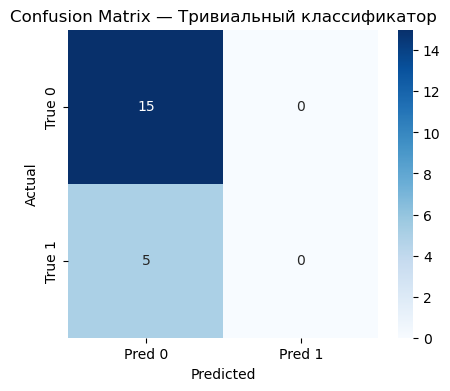

In [61]:
triv = TrivialClassifier()
triv.fit(X_train, y_train)
y_pred_triv = triv.predict(X_test)

print_metrics("Тривиальный классификатор", y_test, y_pred_triv)


Наивный Байес (NB)
------------------
Accuracy:      0.650
Precision:     0.000
Recall:        0.000
F1-score:      0.000
ROC-AUC:       0.433
Confusion matrix:
[[13  2]
 [ 5  0]]


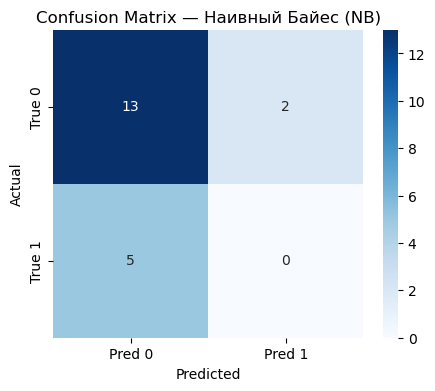

In [63]:
gnb = MyGaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print_metrics("Наивный Байес (NB)", y_test, y_pred_gnb)


k-NN (k=2)
----------
Accuracy:      0.650
Precision:     0.000
Recall:        0.000
F1-score:      0.000
ROC-AUC:       0.433
Confusion matrix:
[[13  2]
 [ 5  0]]


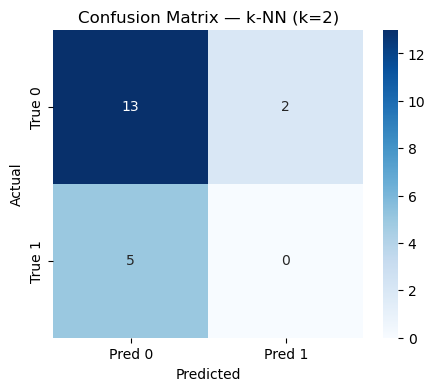

In [65]:
final_knn = KNN(k=best_k)
final_knn.fit(X_train, y_train)
y_pred_knn = final_knn.predict(X_test)

print_metrics(f"k-NN (k={best_k})", y_test, y_pred_knn)


Логистическая регрессия
-----------------------
Accuracy:      0.300
Precision:     0.200
Recall:        0.600
F1-score:      0.300
ROC-AUC:       0.240
Confusion matrix:
[[ 3 12]
 [ 2  3]]


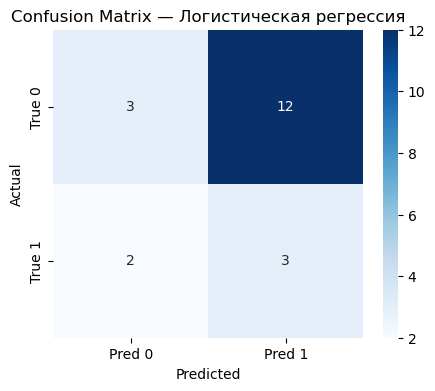

In [67]:
probs_test = log_reg.predict_proba(X_test)
probs_test_1 = probs_test if probs_test.ndim == 1 else probs_test[:, 1]
y_pred_log = (probs_test_1 >= best_thresh).astype(int)

print_metrics("Логистическая регрессия", y_test, y_pred_log, y_prob=probs_test_1)

Проведенный анализ результатов классификации для предсказания формы обучения выявил серьезные проблемы, связанные прежде всего с дисбалансом классов (75%/25%) и слабой предсказательной силой признаков. Тривиальный классификатор показал accuracy 75% за счет предсказания только мажоритарного класса, в то время как Наивный Байес и k-NN (accuracy 65%, ROC-AUC 0.433) оказались хуже случайного угадывания. Логистическая регрессия с низким порогом 0.22 смогла достичь recall 60%, обнаружив большинство случаев миноритарного класса, но ценой крайне низких precision (20%) и accuracy (30%), что привело к многочисленным ложным срабатываниям. Общая низкая производительность всех моделей (ROC-AUC ≤ 0.5) указывает на необходимость решения проблемы дисбаланса данных через техники вроде SMOTE, пересмотра набора признаков и смещения фокуса с accuracy на F1-score и precision-recall метрики для адекватной оценки качества классификации.